<!-- Notebook Header Start -->

<h1 align="center">Changes to Noxious Stimuli by means of Dorsal Root Ganglion Stimulation</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2025-04-26<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **rewrite**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# ➡ Importing Libraries & Data
---

In [1]:
# standard imports
from pathlib import Path
import os
from kilosort import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# custom imports
from automations import RM1
from automations import plots
from automations import analysis_functions
from automations.analysis_functions import MultiRatVonFreyAnalysis

### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

I am running my latest analysis, but with Charlie's probe to make sure that I am doing this right

In [2]:
PROBE_DIRECTORY = Path(r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32_max_murphy_probe.prb")

### filepath definitions

In [3]:
# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(fr'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# save data to the inbox; make sure that the folders: binary & figures exist

# select your path

# the following save directory has already been run, and it stores data that has been unaltered
SAVE_DIRECTORY = Path(fr"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.015 Multi_Rat_Linear_Mixed_Effects_max_probe")

# Create paths if they don't exist
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)

# run a multi-rat class

In [4]:
# all trials
rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW322', 'DW323', 'DW327','DW361']]

# just the one I want for now. you need to pass it as a list, even if it's just one
# rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW361']]

group = RM1.RatGroup(rats)
group.run_preprocessing(remove_drg_stim=True)  # preprocess all rats at once

Reading DRGS_10_240918_140034...
Error reading stream 2 for DRGS_10_240918_140034: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_11_240918_140803...
Error reading stream 2 for DRGS_11_240918_140803: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_12_240918_141655...
Error reading stream 2 for DRGS_12_240918_141655: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_1_240918_125448...
Error reading stream 2 for DRGS_1_240918_125448: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_2_240918_130024...
Error reading stream 2 for DRGS_2_240918_130024: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_3_240918_130835...
Error reading stream 2 for DRGS_3_240918_130835: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_4_240918_131552...
Error reading stream 2 for DRGS_4_240918_131552: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_5_240918_132233...
Error reading stream 2 for DRGS_5_240918_132233: stream_id 2 is not in ['0', '1', '3', '4']
Re

In [5]:
group.rats.keys()

dict_keys(['DW322', 'DW323', 'DW327', 'DW361'])

## run spikeinterface

20250411 update: I am using the bandpass filter (300 Hz - 3000 Hz) from Ting et al. 2024 and the notch filter (60Hz) from Wang et al. 2024

I am using 60 Hz instead of 50 Hz because Wang et al. 2024 was in China, and the supplied power is 50 Hz, and in the US it is 60 Hz

In [6]:
si_wrappers = group.create_spikeinterface_wrappers(SAVE_DIRECTORY)
for rat_id in si_wrappers.keys():
    # si_wrappers[rat_id].save_spinalcord_data_to_binary(bandpass_freq_min=300, bandpass_freq_max=3000, notch_freq=60)
    pass

Preparing SpikeInterface wrapper for rat DW322
Preparing SpikeInterface wrapper for rat DW323
Preparing SpikeInterface wrapper for rat DW327
Preparing SpikeInterface wrapper for rat DW361


## run kilosort & auto-analysis

In [7]:
ks_wrappers = group.create_kilosort_wrappers(SAVE_DIRECTORY, probe_directory=PROBE_DIRECTORY)
def my_custom_criteria(cluster_labels, st, clu, est_contam_rate, fs):   
    # Example criteria: Contamination rate < 15% and firing rate between 0.1 and 1000 Hz
    contam_good = est_contam_rate < 0.15
    fr_good = np.zeros(cluster_labels.size, dtype=bool)
    for i, c in enumerate(cluster_labels):
        spikes = st[clu == c]
        fr = spikes.size / ((spikes.max() - spikes.min()) / fs)
        if 0.1 <= fr <= 200:
            fr_good[i] = True
    return np.logical_and(contam_good, fr_good)

Preparing Kilosort wrapper for DW322
Preparing Kilosort wrapper for DW323
Preparing Kilosort wrapper for DW327
Preparing Kilosort wrapper for DW361


In [8]:
for rat_id in ks_wrappers.keys():
    # ks_wrappers[rat_id].run_kilosort_trial_summary(new_settings="vf_settings_flex_probe",custom_criteria=my_custom_criteria)
    ks_wrappers[rat_id].extract_kilosort_outputs()

Kilosort outputs successfully loaded for trial: VF_1_240918_143256
Kilosort outputs successfully loaded for trial: VF_2_240918_143936
Kilosort outputs successfully loaded for trial: VF_3_240918_144658
Kilosort outputs successfully loaded for trial: VF_4_240918_145638
Kilosort outputs successfully loaded for trial: VF_5_240918_150137
Kilosort outputs successfully loaded for trial: VF_6_240918_150811
Kilosort outputs successfully loaded for trial: VF_7_240918_151516
Kilosort outputs successfully loaded for trial: VF_8_240918_152056
Kilosort outputs successfully loaded for trial: VF_9_240918_152753
Kilosort outputs successfully loaded for trial: VF_1_240911_164342
Kilosort outputs successfully loaded for trial: VF_2_240911_165039
Kilosort outputs successfully loaded for trial: VF_3_240911_165617
Kilosort outputs successfully loaded for trial: VF_4_240911_170446
Kilosort outputs successfully loaded for trial: VF_5_240911_171014
Kilosort outputs successfully loaded for trial: VF_6_240911_17

### pick rat ID you want to look at

In [9]:
rat_id = "DW323"

### Choose a sample trial and cluster

In [10]:
sample_trial = list(ks_wrappers[rat_id].kilosort_results.keys())[0]  # e.g., 'VF_1_240918_143256'
trial_name = sample_trial
sample_cluster = ks_wrappers[rat_id].get_clusters(sample_trial)[32]   # e.g., 39

In [11]:
# Single label (replaces get_good_clusters_from_group)
good_clusters = ks_wrappers[rat_id].get_clusters_by_labels(trial_name, 'good')

# Multiple labels (replaces the old cluster_types='both' approach)
good_and_mua = ks_wrappers[rat_id].get_clusters_by_labels(trial_name, ['good', 'mua'])

# Noise clusters
noise_clusters = ks_wrappers[rat_id].get_clusters_by_labels(trial_name, ['noise'])

# Any custom labels
custom_labels = ks_wrappers[rat_id].get_clusters_by_labels(trial_name, ['custom_label1', 'custom_label2'])

print(f"Good clusters: {good_clusters}")
print(f"Good + MUA clusters: {good_and_mua}")
print(f"Noise clusters: {noise_clusters}")
print(f"Custom labels: {custom_labels}")

Good clusters: [1]
Good + MUA clusters: [1]
Noise clusters: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
Custom labels: []


In [12]:
rat = group.rats["DW323"]
rat

### Analysis with different cluster configurations

In [13]:

# Example 2: Analysis with different cluster configurations
# =========================================================

rat = group.rats["DW323"]

# Method 1: Simple string (same as before, but more flexible)
results1 = rat.get_von_frey_analysis(
    si_wrappers[rat_id], ks_wrappers[rat_id], 
    cluster_labels='good'  # Only good clusters
)

# Method 2: Multiple labels
results2 = rat.get_von_frey_analysis(
    si_wrappers[rat_id], ks_wrappers[rat_id], 
    cluster_labels=['good', 'mua']  # Both good and MUA clusters
)

# Method 3: Custom labels
results3 = rat.get_von_frey_analysis(
    si_wrappers[rat_id], ks_wrappers[rat_id], 
    cluster_labels=['high_quality', 'responsive']  # Custom criteria
)

# Method 4: Per-trial customization
trial_specific_labels = {
    'VF_DRG_1_trial': 'good',
    'VF_DRG_2_trial': ['good', 'mua'],
    'VF_DRG_3_trial': ['good', 'responsive']
}

results4 = rat.get_von_frey_analysis(
    si_wrappers[rat_id], ks_wrappers[rat_id], 
    cluster_labels=trial_specific_labels
)


[DEBUG] get_von_frey_analysis called for rat DW323
[DEBUG] cluster_labels type: <class 'str'>
[DEBUG] cluster_labels value: good
[DEBUG] Getting clusters for trial VF_1_240911_164342 with labels: good
[DEBUG] Found 1 clusters for trial VF_1_240911_164342
[DEBUG] Clusters: [1]
[DEBUG] Getting clusters for trial VF_2_240911_165039 with labels: good
[DEBUG] Found 0 clusters for trial VF_2_240911_165039
[DEBUG] Clusters: []
[DEBUG] Getting clusters for trial VF_3_240911_165617 with labels: good
[DEBUG] Found 1 clusters for trial VF_3_240911_165617
[DEBUG] Clusters: [37]
[DEBUG] Getting clusters for trial VF_4_240911_170446 with labels: good
[DEBUG] Found 3 clusters for trial VF_4_240911_170446
[DEBUG] Clusters: [8, 9, 17]
[DEBUG] Getting clusters for trial VF_5_240911_171014 with labels: good
[DEBUG] Found 0 clusters for trial VF_5_240911_171014
[DEBUG] Clusters: []
[DEBUG] Getting clusters for trial VF_6_240911_171505 with labels: good
[DEBUG] Found 0 clusters for trial VF_6_240911_17150

### Multi-rat analysis with flexible labeling

In [14]:
# Example 3: Multi-rat analysis with flexible labeling
# ====================================================


# Method 1: Same labels for all rats

analyzer= MultiRatVonFreyAnalysis(group, si_wrappers, ks_wrappers)



combined_results1, combined_qst_notes1 = analyzer.analyze_all_trials(
    excel_parent_folder=SAVE_DIRECTORY,
    cluster_labels=['good'],  # Same for all rats
    fast_mode=False,
    skip_correlations=False
)

# # Method 2: Different labels per rat
rat_specific_labels = {
    'DW322': 'mua',  # Only good clusters for DW322
    'DW323': ['mua'],  # Good and MUA for DW323
    'DW327': ['mua']  # Good and responsive for DW327
}

combined_results2, combined_qst_notes2 = analyzer.analyze_all_trials(
    excel_parent_folder=SAVE_DIRECTORY,
    cluster_labels=rat_specific_labels,
    fast_mode=False,
    skip_correlations=False
)

# Method 3: Per-trial customization (most flexible)
nested_labels = {
    'DW322': {
        'VF_DRG_1_trial': 'good',
        'VF_DRG_2_trial': ['good', 'mua']
    },
    'DW323': ['good', 'mua',"noise"],  # Same for all trials in this rat
    'DW327': 'good'
}

# combined_results3, combined_qst_notes3 = analyzer.analyze_all_trials(
#     excel_parent_folder=SAVE_DIRECTORY,
#     cluster_labels=nested_labels,
#     fast_mode=False,
#     skip_correlations=False
# )


[DEBUG] Starting analysis with settings:
  - Cluster labels type: <class 'list'>
  - Cluster labels value: ['good']
  - Fast mode: False
  - Skip correlations: False

[DEBUG] Processing rat: DW322
[DEBUG] Using global labels for DW322: ['good']
[DEBUG] Final kwargs for DW322: {'cluster_labels': ['good']}
[DEBUG] Getting von Frey analysis for DW322

[DEBUG] get_von_frey_analysis called for rat DW322
[DEBUG] cluster_labels type: <class 'list'>
[DEBUG] cluster_labels value: ['good']
[DEBUG] No cached results found in D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.015 Multi_Rat_Linear_Mixed_Effects_max_probe\DW322_['good']\tables
[DEBUG] Getting clusters for trial VF_1_240918_143256 with labels: ['good']
[DEBUG] Found 2 clusters for trial VF_1_240918_143256
[DEBUG] Clusters: [38, 39]
[DEBUG] Getting clusters for trial VF_2_240918_143936 with labels: ['good']
[DEBUG] Found 0 clusters for trial VF_2_240918_143936
[DEBUG] Clusters: []
[DEBUG] Getting clusters for trial VF_3_240918_144658 w

In [15]:
combined_results1

{'DW322_VF_1_240918_143256': {'windows': {'VF_1_240918_143256': {'adjusted_start_times': array([ 3.29383333,  3.2967    ,  3.30033333,  5.85153333,  5.85436667,
            9.81253333, 12.89393333, 17.69113333, 24.09623333, 29.65126667,
           41.0406    , 42.8844    , 46.55056667, 52.25376667, 58.52783333,
           60.62973333, 65.1947    , 65.19923333]),
    'adjusted_end_times': array([ 3.29466667,  3.2983    ,  3.644     ,  5.85233333,  8.17533333,
           11.39853333, 15.03      , 21.02663333, 26.1623    , 32.15416667,
           41.33143333, 45.01033333, 50.5701    , 54.82306667, 59.01406667,
           63.40536667, 65.1948    , 68.22346667])},
   'VF_2_240918_143936': {'adjusted_start_times': array([ 3.34383333,  6.39586667,  6.40456667, 12.63146667, 17.0311    ,
           22.80863333, 26.6608    , 30.2798    , 42.44786667, 45.17636667,
           48.9036    , 53.84803333, 56.55906667, 56.56486667, 63.3006    ,
           66.324     ]),
    'adjusted_end_times': array(

In [16]:
combined_qst_notes1

Trial Number Condition amp PW (us) Freq. (Hz) drgDur. (s)          Stimuli  \
0       DW322_1        VF  51     300          5         180               vf   
1       DW322_2        VF  51     300         20         180               vf   
2       DW322_3        VF  51     300        100         180               vf   
3       DW322_4        VF  51     300        100         180               vf   
4       DW322_5        VF  51     300          5         180               vf   
5       DW322_6        VF  51     300         20         180               vf   
6       DW322_7        VF  51     300          5         180               vf   
7       DW322_8        VF  51     300        100         180               vf   
8       DW322_9        VF  51     300         20         180               vf   
9       DW323_1        VF  70     300          5         180               vf   
10      DW323_2        VF  70     300         20         180               vf   
11      DW323_3        VF  70     300        100         180               vf   
12      DW323_4        VF  70     300        100         180               vf   
13      DW323_5        VF  70     300          5         180               vf   
14      DW323_6        VF  70     300         20         180               vf   
15      DW327_1        vf  63     300          5         180               vf   
16      DW327_2       NaN  63     300        100         180               vf   
17      DW327_3       NaN  63     300        100         180               vf   
18      DW327_4       NaN  63     300          5         180               vf   
19      DW327_5       NaN  63     300         20         180               vf   
20      DW327_6       NaN  63     300         20         180               vf   
21      DW327_7       NaN  63     300          5         180               vf   
22      DW327_8       NaN  63     300        100         180               vf   
23      DW327_9       NaN  63     300        100         180               vf   
24     DW327_10       NaN  63     300          5         180               vf   
25      DW361_1        VF  69     300          5           3              NaN   
26      DW361_2        VF  69     300          5         180              NaN   
27      DW361_3        VF  69     300         20         180  change freq 100   
28      DW361_4        VF  69     300        100         180              NaN   
29      DW361_5        VF  69     300         20         180              NaN   
30      DW361_6        VF  69     300          5         180              NaN   
31      DW361_7        VF  69     300        100         180              NaN   
32      DW361_8        VF  69     300          5         180              NaN   
33      DW361_9        VF  69     300        100         180              NaN   
34     DW361_10        VF  69     300         20         180              NaN   
35     DW361_11        VF  69     300          5         180              NaN   
36     DW361_12        VF  69     300         20         180              NaN   
37     DW361_13        VF  69     300        100         180              NaN   
38     DW361_14        VF  69     300          5         180              NaN   
39     DW361_15        VF  69     300         20         180              NaN   
40     DW361_16        VF  69     300        100         180              NaN   

   temp Stimuli Dur.                          NaN Rat ID  \
0   NaN            30  accidentally named DRGS_13  DW322   
1   NaN            30                         NaN  DW322   
2   NaN            30                         NaN  DW322   
3   NaN            30                         NaN  DW322   
4   NaN            30                         NaN  DW322   
5   NaN            30                         NaN  DW322   
6   NaN            30                         NaN  DW322   
7   NaN            30                         NaN  DW322   
8   NaN            30                         NaN  DW322   


In [17]:
# import pandas as pd

# cluster_labels_xlsx = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.015 Multi_Rat_Linear_Mixed_Effects_max_probe\cluster_labels.xlsx"
# def build_cluster_label_dict(cluster_labels_xlsx, allowed_labels, combined_results):
#     df = pd.read_excel(cluster_labels_xlsx)
#     # Ensure columns are named as expected
#     df.columns = [col.strip() for col in df.columns]
#     cluster_dict = {}
#     for trial_name in combined_results.keys():
#         rat_id = trial_name.split('_')[0]
#         # Get allowed clusters for this rat and allowed labels
#         allowed_clusters = df[
#             (df['Rat'] == rat_id) & (df['Label'].isin(allowed_labels))
#         ]['Cluster'].tolist()
#         cluster_dict[trial_name] = allowed_clusters
#     return cluster_dict

In [18]:

cluster_labels_xlsx = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.015 Multi_Rat_Linear_Mixed_Effects_max_probe\cluster_labels.xlsx"
# def build_cluster_label_dict(cluster_labels_xlsx, allowed_labels, combined_results):

combined_results, combined_qst_notes = analyzer.analyze_all_trials(
    excel_parent_folder=SAVE_DIRECTORY,
    cluster_labels=['good', 'mua'],  # or any filter (string, list, dict, nested)
    # cluster_labels_xlsx=cluster_labels_xlsx,  # <--- NEW ARGUMENT
    fast_mode=False,
    skip_correlations=False
)


[DEBUG] Starting analysis with settings:
  - Cluster labels type: <class 'list'>
  - Cluster labels value: ['good', 'mua']
  - Fast mode: False
  - Skip correlations: False

[DEBUG] Processing rat: DW322
[DEBUG] Using global labels for DW322: ['good', 'mua']
[DEBUG] Final kwargs for DW322: {'cluster_labels': ['good', 'mua']}
[DEBUG] Getting von Frey analysis for DW322

[DEBUG] get_von_frey_analysis called for rat DW322
[DEBUG] cluster_labels type: <class 'list'>
[DEBUG] cluster_labels value: ['good', 'mua']
[DEBUG] No cached results found in D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.015 Multi_Rat_Linear_Mixed_Effects_max_probe\DW322_['good', 'mua']\tables
[DEBUG] Getting clusters for trial VF_1_240918_143256 with labels: ['good', 'mua']
[DEBUG] Found 33 clusters for trial VF_1_240918_143256
[DEBUG] Clusters: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 38, 39]
[DEBUG] Getting clusters for trial VF_2_240918_1


Plotting with correlation threshold: 0.3
Number of trials in combined_results: 39
[DEBUG] Created frequency dictionary with 30 entries
[DEBUG] Available frequencies: [5, 20, 100, 5, 20, 5, 100, 20, 5, 20, 100, 100, 20, 5, 5, 5, 20, 100, 20, 5, 100, 5, 100, 20, 5, 20, 100, 5, 20, 100]

Processing trial: DW322_VF_1_240918_143256
[DEBUG] Clusters to plot for DW322_VF_1_240918_143256 (labels ['good']): [38, 39]
[DEBUG] Correlation keys for DW322_VF_1_240918_143256: ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_9', 'cluster_10', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32', 'cluster_38', 'cluster_39']
[DEBUG] Correlation values for DW322_VF_1_240918_143256: [0.4063242814844127, 0

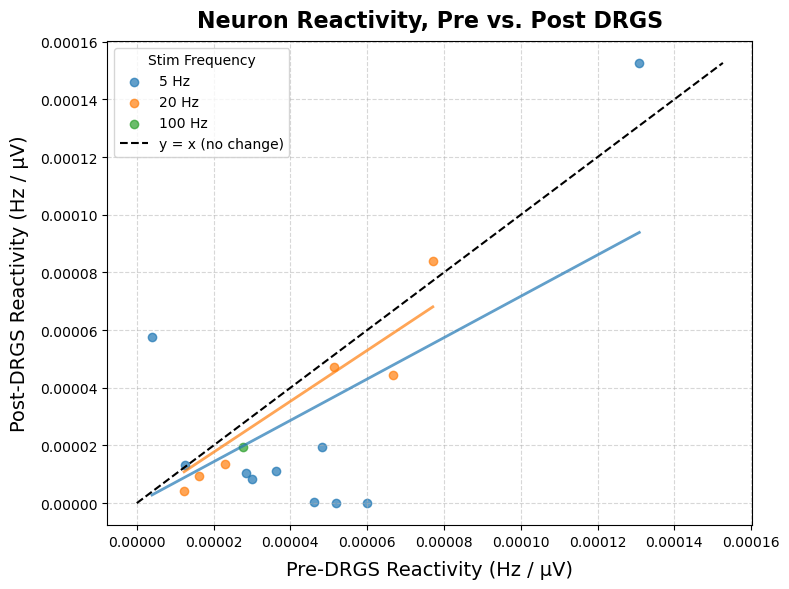

In [19]:
plots.vf_all_trials_combined_plot(
    combined_results,
    combined_qst_notes,
    ks_wrappers,
    corr_threshold=0.3,
    cluster_labels=['good',],  # or any filter
    # cluster_labels_xlsx=cluster_labels_xlsx   # <--- NEW ARGUMENT
)


Plotting with correlation threshold: 0.3
Number of trials in combined_results: 39
[DEBUG] Created frequency dictionary with 30 entries
[DEBUG] Available frequencies: [5, 20, 100, 5, 20, 5, 100, 20, 5, 20, 100, 100, 20, 5, 5, 5, 20, 100, 20, 5, 100, 5, 100, 20, 5, 20, 100, 5, 20, 100]

Processing trial: DW322_VF_1_240918_143256
[DEBUG] Clusters to plot for DW322_VF_1_240918_143256 (labels ['good', 'mua']): [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 38, 39]
[DEBUG] Correlation keys for DW322_VF_1_240918_143256: ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_9', 'cluster_10', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31',

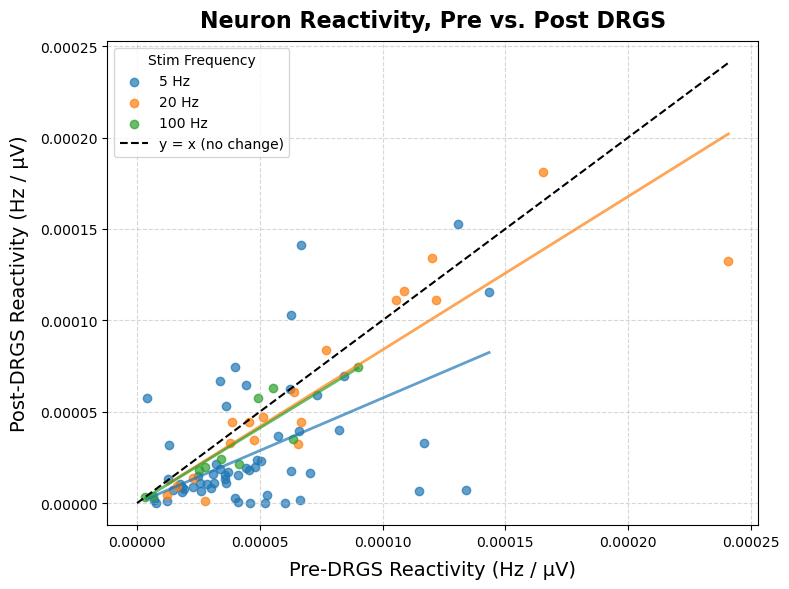

In [22]:
plots.vf_all_trials_combined_plot(
    combined_results,
    combined_qst_notes,
    ks_wrappers,
    corr_threshold=0.3,
    cluster_labels=['good',"mua"],  # or any filter
    # cluster_labels_xlsx=cluster_labels_xlsx   # <--- NEW ARGUMENT
)


Plotting with correlation threshold: 0.001
Number of trials in combined_results: 31
[DEBUG] Created frequency dictionary with 23 entries
[DEBUG] Available frequencies: [5, 5, 20, 5, 100, 20, 5, 100, 100, 5, 5, 5, 20, 100, 20, 100, 5, 100, 20, 5, 20, 100, 5]

Processing trial: DW322_VF_1_240918_143256
[DEBUG] Clusters to plot for DW322_VF_1_240918_143256 (labels ['good']): [38, 39]
[DEBUG] Correlation keys for DW322_VF_1_240918_143256: ['cluster_38', 'cluster_39']
[DEBUG] Correlation values for DW322_VF_1_240918_143256: [0.32782855032271313, 0.16393767104034757]
[DEBUG] Using correlation threshold: 0.001
[DEBUG] Cluster columns in firing_data: ['cluster_38', 'cluster_39']
[DEBUG] Cluster columns types: [<class 'str'>, <class 'str'>]
Total clusters in analysis: 2
[DEBUG] Checking cluster column: cluster_38 (int: 38)
[DEBUG]   - Match with clusters_to_plot: True
[DEBUG]   - Correlation value: 0.32782855032271313
[DEBUG]   - Cluster cluster_38 passed correlation threshold with value 0.328

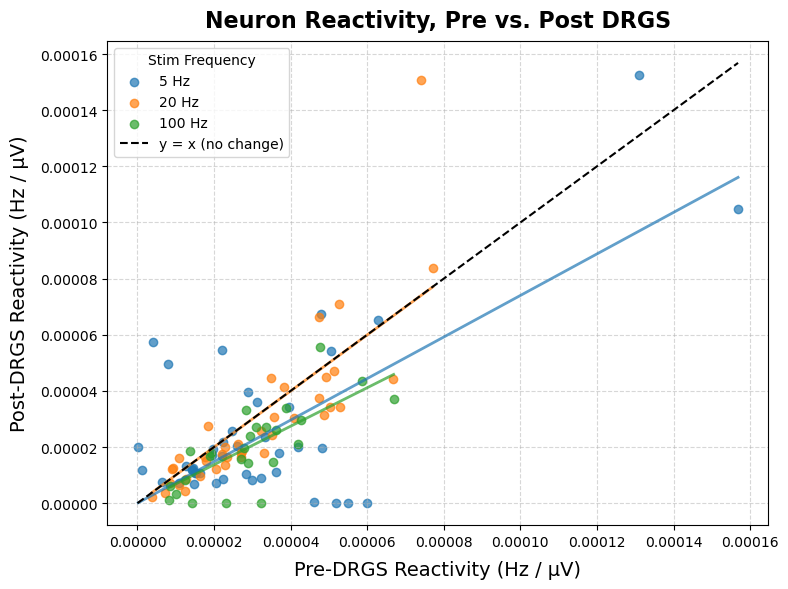

In [24]:
allowed_labels = ['good']  # or any list you want

plots.vf_all_trials_combined_plot(
    combined_results1,
    combined_qst_notes1,
    ks_wrappers,
    corr_threshold=0.001,
    cluster_labels=allowed_labels,
    # cluster_labels_xlsx=cluster_labels_xlsx
)


Plotting with correlation threshold: 0.001
Number of trials in combined_results: 31
[DEBUG] Created frequency dictionary with 23 entries
[DEBUG] Available frequencies: [5, 5, 20, 5, 100, 20, 5, 100, 100, 5, 5, 5, 20, 100, 20, 100, 5, 100, 20, 5, 20, 100, 5]

Processing trial: DW322_VF_1_240918_143256
[DEBUG] Clusters to plot for DW322_VF_1_240918_143256 (labels ['good', 'mua']): [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 38, 39]
[DEBUG] Correlation keys for DW322_VF_1_240918_143256: ['cluster_38', 'cluster_39']
[DEBUG] Correlation values for DW322_VF_1_240918_143256: [0.32782855032271313, 0.16393767104034757]
[DEBUG] Using correlation threshold: 0.001
[DEBUG] Cluster columns in firing_data: ['cluster_38', 'cluster_39']
[DEBUG] Cluster columns types: [<class 'str'>, <class 'str'>]
Total clusters in analysis: 2
[DEBUG] Checking cluster column: cluster_38 (int: 38)
[DEBUG]   - Match with clusters_to_plot: True
[DEBU

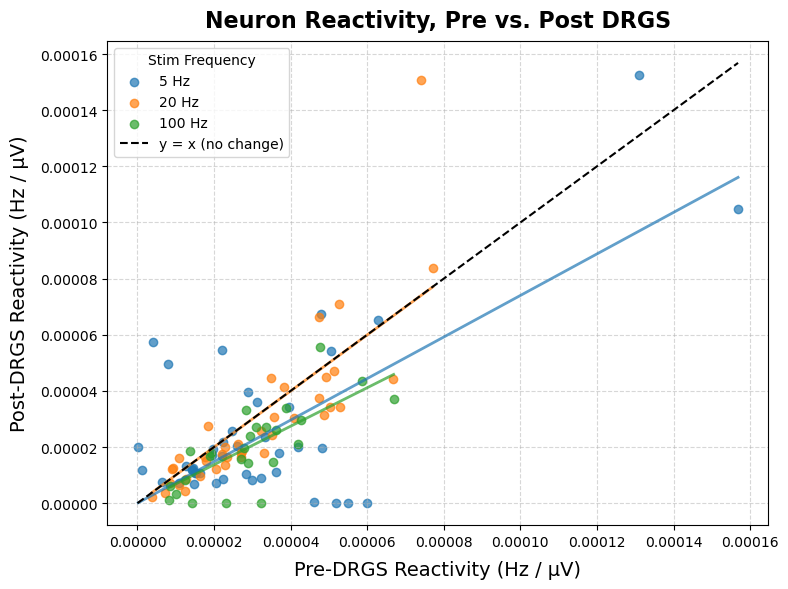


Plotting with correlation threshold: 0.001
Number of trials in combined_results: 35
[DEBUG] Created frequency dictionary with 26 entries
[DEBUG] Available frequencies: [5, 20, 100, 5, 20, 5, 100, 20, 20, 100, 100, 20, 5, 5, 5, 20, 100, 20, 100, 5, 100, 20, 5, 20, 100, 5]

Processing trial: DW322_VF_1_240918_143256
[DEBUG] Clusters to plot for DW322_VF_1_240918_143256 (from external mapping): []
[DEBUG] Correlation keys for DW322_VF_1_240918_143256: ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_9', 'cluster_10', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32']
[DEBUG] Correlation values for DW322_VF_1_240918_143256: [0.4063242814844127, 0.24150528208562685, 0.06932612365804451, 

In [26]:
plots.vf_all_trials_combined_plot(combined_results1,
                                combined_qst_notes1,
                                ks_wrappers,
                                corr_threshold=0.001,
                                cluster_labels=["good","mua"])   
plots.vf_all_trials_combined_plot(combined_results2, 
                                  combined_qst_notes2,
                                  ks_wrappers,
                                  corr_threshold=0.001,   
                                  cluster_labels=rat_specific_labels)   
# plots.vf_all_trials_combined_plot(combined_results3, 
#                                   combined_qst_notes3,
#                                   ks_wrappers,
#                                   corr_threshold=0.01,
#                                   cluster_labels=nested_labels)   

In [ ]:

# # Example 4: Performance optimizations
# # ====================================

# # For large datasets, use performance optimizations
# results_optimized = analyzer.analyze_all_trials(
#     excel_parent_folder=SAVE_DIRECTORY,
#     cluster_labels='good',
#     fast_mode=True,  # Enables faster processing for large cluster counts
#     skip_correlations=True,  # Skip correlation computation for speed
#     # correlation_window_size=5000,  # Smaller window for faster correlation
#     subwindow_width=0.5  # Analysis parameter
# )
